In [1]:
import sys

sys.path.append('/home/luo3300612/Workspace/PycharmWS/mySuperPoint/superpoint/model')

import torch
import matplotlib.pyplot as plt 
import torch.nn as nn
from utils import SuperPointFrontend
from data import get_test
import numpy as np
from dataset import point2label
from tqdm import tqdm

In [2]:
net = torch.load('/home/luo3300612/Workspace/PycharmWS/mySuperPoint/superpoint/result/epoch120',map_location='cpu')

In [3]:
test_data = get_test({"SyntheticData":{"only_point":True}},loader=False)
sample_index = np.random.randint(0,4500,(1000,))
test_sample = [test_data[i] for i in sample_index]

In [4]:
def pr_pts(heat_map,label,positive=True):
    if positive:
        index = list(reversed(np.argsort(heat_map,axis=None).tolist()))
    else:
        index = np.argsort(heat_map,axis=None).tolist()
        label = np.logical_not(label)
    
    AP_positive = 0
    pred_label = np.zeros_like(label,dtype=int)
    
    pr_curve = np.zeros((heat_map.shape[0]*heat_map.shape[1]+2,2))
    pr_curve[0,0] = 0
    pr_curve[0,1] = 1
    pr_curve[-1,0] = 1
    pr_curve[-1,1] = 0
    
    
    pred_positive_sample_num = 0
    precision_pts = []
    for i in range(len(index)):
        r,c = one2two(index[i],*heat_map.shape)
        pred_label[r,c] = 1

        pred_positive_sample_num += 1
        positive_sample_num = np.sum(label)
        
        if positive_sample_num == 0:  # 剪枝            
            for j in range(i,len(index)):
                pr_curve[j+1,0] = 1  # recall = 1
                pr_curve[j+1,1] = 0  # precision = 0
            precision_pts.append([0,1])
            # precision_pts.append([1,0])
            break
        else:
            TP = np.sum(np.logical_and(pred_label,label))
            precision = TP/pred_positive_sample_num
            recall = TP/positive_sample_num
            
            if recall != 0 and recall != pr_curve[i,0]:
                precision_pts.append([recall,precision])
            
            pr_curve[i+1,0] = recall
            pr_curve[i+1,1] = precision
    return pr_curve,np.array(precision_pts)
            
    
def one2two(index,row,col):
    r = index//col
    c = index%col
    return r,c


    

In [5]:
from utils import output2points

In [6]:
def get_heatmap(sample):
    img = sample['img']
    pts = sample['pt']
    img_tensor = torch.tensor(img)
    img_tensor = img_tensor.view((1,1,*img.shape))
    output = net(img_tensor)
    output = output.squeeze()
    output = np.exp(output.detach().numpy())  # Softmax.
    output = output / (np.sum(output, axis=0) + .00001)  # Should sum to 1.
    output = output[:-1, :, :]
    output = output.transpose(1, 2, 0)
    output = output.reshape((15, 20, 8, 8))
    output = output.transpose(0, 2, 1, 3)
    heatmap = output.reshape(120, 160)
    return heatmap
                                 
def visulize_pr(sample):
    """
    visulize p-r curve of an img
    """
    img = sample['img']
    pts = sample['pt']
    label = point2label(pts,binary=True)
    heatmap = get_heatmap(sample)
                                 
    pts,precision_pts= pr_pts(heatmap,label,True)

    plt.plot(pts[:,0],pts[:,1])
    plt.scatter(precision_pts[:,0],precision_pts[:,1],color='r')
    plt.show()
    plt.imshow(img)
    plt.show()
                                 
def mAP(sample):
    label = point2label(sample['pt'],binary=True)
    heatmap = get_heatmap(sample)
    pts_pos,precision_pts_pos = pr_pts(heatmap,label,True)
    pts_ne,precision_ne = pr_pts(heatmap,label,False)
    
    mAP = (np.mean(precision_pts_pos[:,1]) + np.mean(precision_ne[:,1]))/2
    return mAP

In [112]:
from tqdm import tqdm
mAP_sum = 0
for sample in tqdm(test_sample):
    mAP_sum += mAP(sample)
print(f"AVG. map = {mAP_sum/1000:.4f}")

100%|██████████| 1000/1000 [32:45<00:00,  1.98s/it]

AVG. map = 0.8086


In [117]:
from tqdm import tqdm
mAP_sum = 0
for sample in tqdm(test_sample):
    mAP_sum += mAP(sample)
print(f"AVG. map = {mAP_sum/1000:.4f}")

100%|██████████| 1000/1000 [32:13<00:00,  2.01s/it]

AVG. map = 0.8696


In [8]:
def mAP_fix(test_sample):
        
    conf_list = []
    label_list = []
    
    for sample in tqdm(test_sample):
        heatmap = list(get_heatmap(sample).reshape((-1,)))
        label = list(point2label(sample['pt'],binary=True).reshape((-1,)))
        conf_list += heatmap
        label_list += label
    
    conf_list = np.array(conf_list)
    label = np.array(label_list)
    
    index = list(reversed(np.argsort(conf_list).tolist()))
    
    pred_label = np.zeros_like(conf_list)
    
    pred_positive_sample_num = 0
    precision_pts = []
    pr_curve = np.zeros((len(index)+2,2))
    
    pr_curve[0,0] = 0
    pr_curve[0,1] = 1
    pr_curve[-1,0] = 1
    pr_curve[-1,1] = 0
    
    TP = 0
    positive_sample_num = np.sum(label)
    print(len(index))
    for i in tqdm(range(len(index))):
        
        ind = index[i]
        
        pred_label[ind] = 1
        
        pred_positive_sample_num += 1
        
        
        if label[ind] == 1:
            TP += 1
        precision = TP/pred_positive_sample_num
        recall = TP/positive_sample_num
        
        if recall != 0 and recall != pr_curve[i,0]:
            precision_pts.append([recall,precision])

        pr_curve[i+1,0] = recall
        pr_curve[i+1,1] = precision
    
    return pr_curve,np.array(precision_pts)


In [9]:
pr_curve,precision_pts = mAP_fix(test_sample)

  0%|          | 248/19200000 [00:00<4:14:48, 1255.82it/s]

19200000


100%|██████████| 19200000/19200000 [00:27<00:00, 704725.78it/s]


In [10]:
np.save("pr_curve.npy",pr_curve)
np.save("precision_pts.npy",precision_pts)

In [21]:
pr_curve = np.load("pr_curve.npy")

In [30]:
pr_curve.shape

(19200002, 2)

In [38]:
pr_curve[6,0]

0.9940089865202196

In [27]:
print(pr_curve.shape)

(19200002, 2)


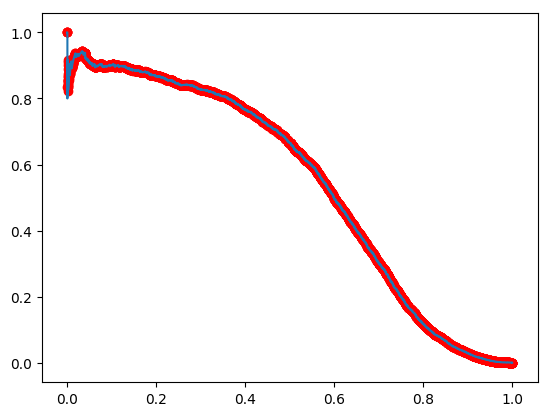

In [21]:
import matplotlib
matplotlib.rcParams['agg.path.chunksize'] = 1920000200000000
matplotlib.rcParams.update( matplotlib.rc_params() )
plt.plot(pr_curve[:,0],pr_curve[:,1])
plt.scatter(precision_pts[:,0],precision_pts[:,1],color='r')
plt.show()

In [7]:
def mAP_final(test_sample):
       
    epsilon = 4
    
    conf_list = []
    label_list = []
    mask_list = []
    
    for sample in tqdm(test_sample):
        heatmap = list(get_heatmap(sample).reshape((-1,)))
        
        pts = sample['pt'].astype(int)
        label = point2label(pts,binary=True)
        
        label_mask = label.copy()
        
        for point in pts:
            x,y = point
            label_mask[max(x-epsilon,0):min(x+epsilon,label.shape[0]),max(y-epsilon,0):min(y+epsilon,label.shape[1])] = 1
        
        label = list(label.reshape((-1,1)))
        label_mask = list(label_mask.reshape((-1,1)))
        
        conf_list += heatmap
        label_list += label
        mask_list += label_mask
    
    conf_list = np.array(conf_list)
    label = np.array(label_list)
    label_mask = np.array(mask_list)
    
    index = list(reversed(np.argsort(conf_list).tolist()))
    
    pred_label = np.zeros_like(conf_list)
    
    pred_positive_sample_num = 0
    precision_pts = []
    pr_curve = np.zeros((len(index)+2,2))
    
    pr_curve[0,0] = 0
    pr_curve[0,1] = 1
    pr_curve[-1,0] = 1
    pr_curve[-1,1] = 0
    
    TP = 0
    positive_sample_num = np.sum(label)
    print(len(index))
    for i in tqdm(range(len(index))):
        
        ind = index[i]
        
        pred_label[ind] = 1
        
        pred_positive_sample_num += 1
        
        
        if label[ind] == 1:
            TP += 1
        elif  label_mask[ind] == 1:
            TP += 1
            positive_sample_num += 1


         

        precision = TP/pred_positive_sample_num
        recall = TP/positive_sample_num
        
        if recall != 0 and recall != pr_curve[i,0]:
            precision_pts.append([recall,precision])

        pr_curve[i+1,0] = recall
        pr_curve[i+1,1] = precision
    
    return pr_curve,np.array(precision_pts)


In [8]:
pr_curve,precision_pts = mAP_final(test_sample)

  0%|          | 0/19200000 [00:00<?, ?it/s]

19200000


100%|██████████| 19200000/19200000 [01:04<00:00, 295486.01it/s]


In [10]:
np.save("pr_curve.npy",pr_curve)
np.save("precision_pts.npy",precision_pts)

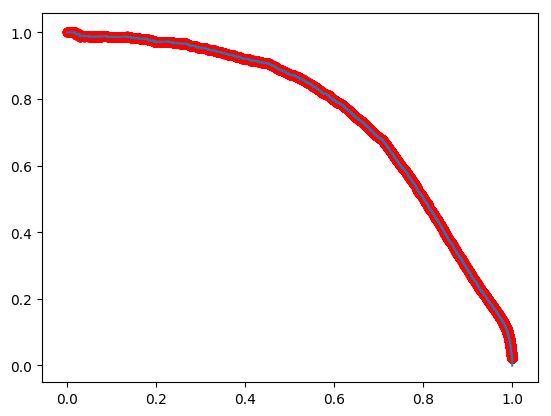

In [9]:
import matplotlib
matplotlib.rcParams['agg.path.chunksize'] = 1920000200000000
matplotlib.rcParams.update( matplotlib.rc_params() )
plt.plot(pr_curve[:,0],pr_curve[:,1])
plt.scatter(precision_pts[:,0],precision_pts[:,1],color='r')
plt.show()

In [11]:
print(np.mean(precision_pts[:,1]))

0.06039093713881635


In [14]:
precision_pts=np.array(precision_pts)
print(np.mean(precision_pts[:,1]))

0.5441141390297709


In [7]:
def mAP_final(test_sample):
       
    epsilon = 4
    
    conf_list = []
    label_list = []
    mask_list = []
    index_map_list = []
    
    for sample in tqdm(test_sample):
        
        pts = sample['pt'].astype(int)
        label = point2label(pts,binary=True)
        
        label_mask = label.copy()
        
        index_map = np.zeros_like(label)
# check index map code        
#         x = 0
#         y = 0
        for point in pts:
            x,y = point
            label_mask[max(x-epsilon,0):min(x+epsilon,label.shape[0]),max(y-epsilon,0):min(y+epsilon,label.shape[1])] = 1
            index_map[max(x-epsilon,0):min(x+epsilon,label.shape[0]),max(y-epsilon,0):min(y+epsilon,label.shape[1])] = x*160+y+len(label_list)
        
        heatmap = get_heatmap(sample)
# check index map code
#         if pts.shape[0] !=0:
#             try:
#                 assert heatmap[x,y] == tmp[index_map[x-1,y-1]]
#                 print("correct")
#             except AssertionError:
#                 print(f"{heatmap[x,y]}!={tmp[index_map[x-1,y-1]]},\nwhen index_map[{x-1},{y-1}]=={index_map[x-1,y-1]}")
#                 print("where",np.where(tmp==heatmap[x,y]))
#                 raise
        heatmap = list(heatmap.reshape((-1,)))
        label = list(label.reshape((-1,)))
        label_mask = list(label_mask.reshape((-1,)))
        index_map = list(index_map.reshape((-1,)))
        
        conf_list += heatmap
        label_list += label
        mask_list += label_mask
        index_map_list += index_map
        
    
    conf_list = np.array(conf_list)
    label = np.array(label_list)
    label_mask = np.array(mask_list)
    index_map = np.array(index_map_list)
    
    index = list(reversed(np.argsort(conf_list).tolist()))
        
    pred_positive_sample_num = 0
    precision_pts = []
    pr_curve = np.zeros((len(index)+2,2))
    
    pr_curve[0,0] = 0
    pr_curve[0,1] = 1
    pr_curve[-1,0] = 1
    pr_curve[-1,1] = 0
    
    TP = 0
    positive_sample_num = np.sum(label)
    pred_label = np.zeros_like(conf_list)

    for i in tqdm(range(len(index))):
        
        ind = index[i]
#         if label[ind] == 1:
#             TP += 1
#         elif  label_mask[ind] == 1:
#             TP += 1
#             positive_sample_num += 1

        pred_positive_sample_num += 1
        

        if label_mask[ind] == 1:
            origin_index = index_map_list[ind]
            if pred_label[origin_index] == 1:
                pred_positive_sample_num -= 1
            else:
                pred_label[origin_index] = 1
                TP += 1

        precision = TP/pred_positive_sample_num
        recall = TP/positive_sample_num
        
        if recall != 0 and recall != pr_curve[i,0]:
            precision_pts.append([recall,precision])

        pr_curve[i+1,0] = recall
        pr_curve[i+1,1] = precision
    
    return pr_curve,np.array(precision_pts)


In [8]:
pr_curve,precision_pts = mAP_final(test_sample)

100%|██████████| 19200000/19200000 [00:28<00:00, 678642.66it/s]


In [9]:
np.save("pr_curve.npy",pr_curve)
np.save("precision_pts.npy",precision_pts)

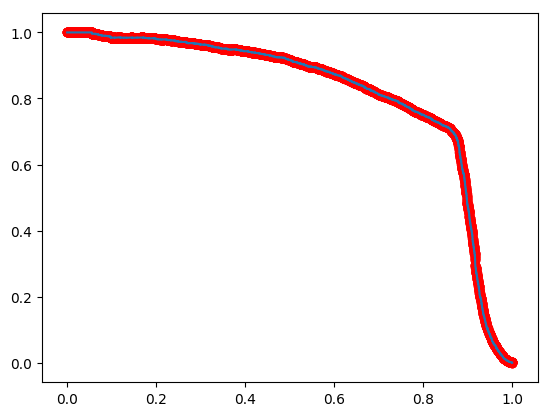

In [10]:
import matplotlib
matplotlib.rcParams['agg.path.chunksize'] = 1920000200000000
matplotlib.rcParams.update( matplotlib.rc_params() )
plt.plot(pr_curve[:,0],pr_curve[:,1])
plt.scatter(precision_pts[:,0],precision_pts[:,1],color='r')
plt.show()

In [11]:
np.mean(precision_pts[:,1])

0.8189646193634157

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = test_data[0]['img']

fast=cv2.FastFeatureDetector_create(threshold=20,nonmaxSuppression=True,type=cv2.FAST_FEATURE_DETECTOR_TYPE_9_16)#获取FAST角点探测器


kp=fast.detect(img,None)#描述符

img = cv2.drawKeypoints(img,kp,img,color=(255,0,0))#画到img上面

print ("Threshold: ", fast.getThreshold())#输出阈值
print ("nonmaxSuppression: ", fast.getNonmaxSuppression())#是否使用非极大值抑制
print ("Total Keypoints with nonmaxSuppression: ", len(kp))#特征点个数

plt.imshow(img)